# Proyek Klasifikasi Gambar: RICE IMAGE DATASET
- **Nama:** Labib Hakam Fauzi
- **Email:** mc012d5y1465@student.devacademy.id
- **ID Dicoding:** mc012d5y1465
- **Link Dataset:** https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
!gdown 17GHDfCyurcvi-Y4M3qm-i9Sk9qCuf93S

Downloading...
From (original): https://drive.google.com/uc?id=17GHDfCyurcvi-Y4M3qm-i9Sk9qCuf93S
From (redirected): https://drive.google.com/uc?id=17GHDfCyurcvi-Y4M3qm-i9Sk9qCuf93S&confirm=t&uuid=8c52a2e9-cbe9-43cf-81c2-e094a7ce56d1
To: /content/beras.zip
100% 230M/230M [00:03<00:00, 58.9MB/s]


In [4]:
! unzip "/content/beras.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [5]:
os.listdir()

['.config', 'Rice_Image_Dataset', 'beras.zip', 'sample_data']

In [6]:
os.listdir('Rice_Image_Dataset')

['Arborio',
 'Ipsala',
 'Jasmine',
 'Basmati',
 'Karacadag',
 'Rice_Citation_Request.txt']

In [7]:
import os

files_to_delete = ['Rice_Image_Dataset/Rice_Citation_Request.txt']

for file_path in files_to_delete:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted file: {file_path}")
    else:
        print(f"File not found: {file_path}")

Deleted file: Rice_Image_Dataset/Rice_Citation_Request.txt


Displaying images from Rice_Image_Dataset/Karacadag:


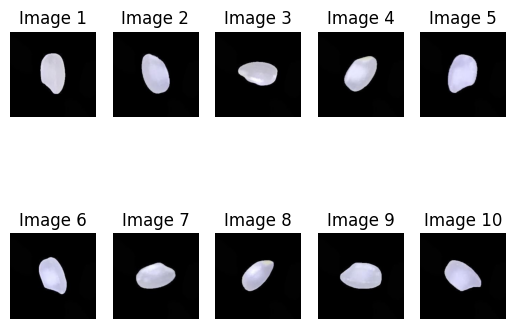

Displaying images from Rice_Image_Dataset/Basmati:


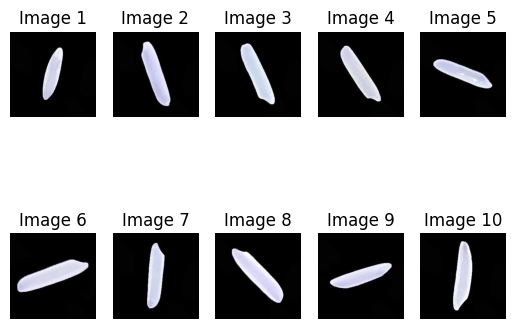

Displaying images from Rice_Image_Dataset/Jasmine:


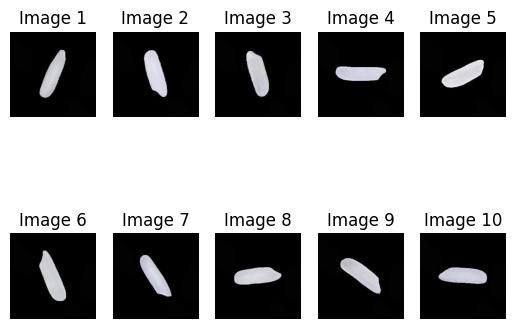

Displaying images from Rice_Image_Dataset/Arborio:


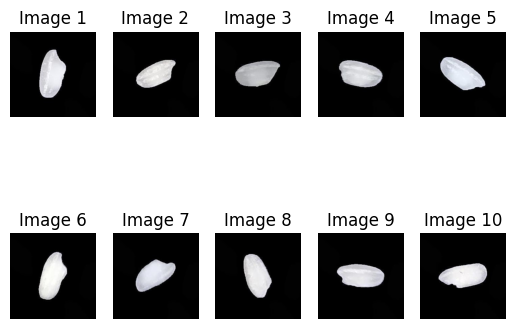

Displaying images from Rice_Image_Dataset/Ipsala:


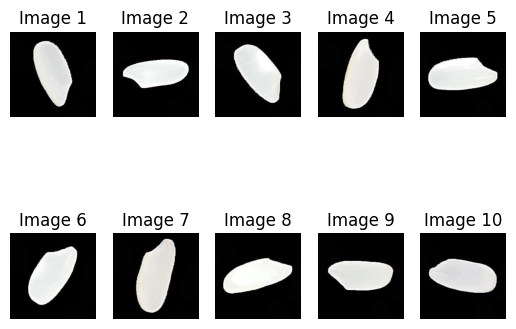

In [8]:
# Menampilkan img dataset by folder

def display_images(folder_path, num_images=10):
    """Displays the first 'num_images' from a folder."""

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

    for i in range(min(num_images, len(image_files))):
        img_path = os.path.join(folder_path, image_files[i])
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()

folders = ['Rice_Image_Dataset/Karacadag', 'Rice_Image_Dataset/Basmati','Rice_Image_Dataset/Jasmine', 'Rice_Image_Dataset/Arborio','Rice_Image_Dataset/Ipsala'] # Adjust subfolder names if needed

for folder in folders:
    print(f"Displaying images from {folder}:")
    display_images(folder)

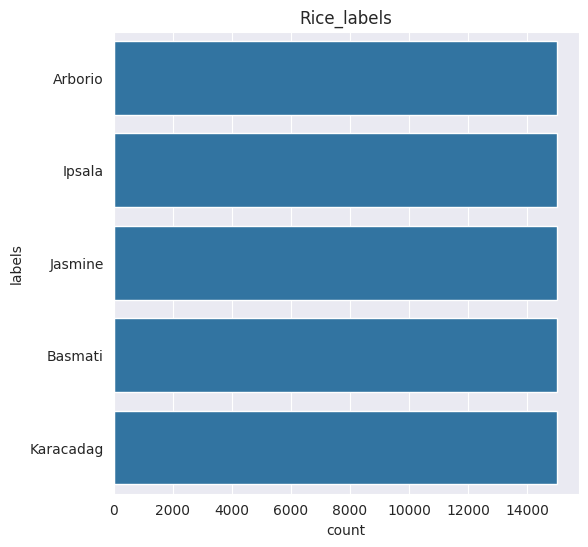

In [9]:
# Menampilkan banyaknya plot pada dataset
# Define source path
img_path = "Rice_Image_Dataset"
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(img_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot dataset berdasarkan kelas
Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)
plot_data.set_title("Rice_labels")
plt.show()

In [10]:
df.head()

,path,file_name,labels
0,Rice_Image_Dataset/Arborio/Arborio (689).jpg,Arborio (689).jpg,Arborio
1,Rice_Image_Dataset/Arborio/Arborio (6226).jpg,Arborio (6226).jpg,Arborio
2,Rice_Image_Dataset/Arborio/Arborio (8047).jpg,Arborio (8047).jpg,Arborio
3,Rice_Image_Dataset/Arborio/Arborio (1626).jpg,Arborio (1626).jpg,Arborio
4,Rice_Image_Dataset/Arborio/Arborio (5387).jpg,Arborio (5387).jpg,Arborio


In [11]:
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


### Data Preprocessing

#### Split Dataset

In [12]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=300)

In [13]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 52500
test size 22500


In [15]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   Arborio       4518
       Basmati       4487
       Ipsala        4448
       Jasmine       4591
       Karacadag     4456
train  Arborio      10482
       Basmati      10513
       Ipsala       10552
       Jasmine      10409
       Karacadag    10544
dtype: int64 


                                                    path     labels    set
5121   Rice_Image_Dataset/Karacadag/Karacadag (12101)...  Karacadag  train
46415        Rice_Image_Dataset/Ipsala/Ipsala (2079).jpg     Ipsala  train
10338  Rice_Image_Dataset/Karacadag/Karacadag (7945).jpg  Karacadag  train
61293     Rice_Image_Dataset/Basmati/basmati (11139).jpg    Basmati   test
55585      Rice_Image_Dataset/Arborio/Arborio (9055).jpg    Arborio   test


In [16]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Rice_Image_Dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [18]:
os.listdir()

['.config', 'Dataset-Final', 'Rice_Image_Dataset', 'beras.zip', 'sample_data']

In [19]:
os.listdir('Dataset-Final')

['train', 'test']

In [20]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_Karacadag = os.path.join(TRAIN_DIR + '/Karacadag')
train_Basmati = os.path.join(TRAIN_DIR + '/Basmati')
train_Jasmine = os.path.join(TRAIN_DIR + '/Jasmine')
train_Arborio = os.path.join(TRAIN_DIR + '/Arborio')
train_Ipsala = os.path.join(TRAIN_DIR + '/Ipsala')

test_Karacadag = os.path.join(TEST_DIR + '/Karacadag')
test_Basmati = os.path.join(TEST_DIR + '/Basmati')
test_Jasmine = os.path.join(TEST_DIR + '/Jasmine')
test_Arborio = os.path.join(TEST_DIR + '/Arborio')
test_Ipsala = os.path.join(TRAIN_DIR + '/Ipsala')

print("Total number of Karacadag images in training set: ",len(os.listdir(train_Karacadag)))
print("Total number of Basmati images in training set: ",len(os.listdir(train_Basmati)))
print("Total number of Jasmine images in training set: ",len(os.listdir(train_Jasmine)))
print("Total number of Arborio images in training set: ",len(os.listdir(train_Arborio)))
print("Total number of Ipsala images in training set: ",len(os.listdir(train_Ipsala)))
print("===============================================")
print("Total number of Karacadag images in test set: ",len(os.listdir(test_Karacadag)))
print("Total number of Basmati images in test set: ",len(os.listdir(test_Basmati)))
print("Total number of Jasmine images in test set: ",len(os.listdir(test_Jasmine)))
print("Total number of Arborio images in test set: ",len(os.listdir(test_Arborio)))
print("Total number of Ipsala images in test set: ",len(os.listdir(test_Ipsala)))

Total number of Karacadag images in training set:  10544
Total number of Basmati images in training set:  10513
Total number of Jasmine images in training set:  10409
Total number of Arborio images in training set:  10482
Total number of Ipsala images in training set:  10552
Total number of Karacadag images in test set:  4456
Total number of Basmati images in test set:  4487
Total number of Jasmine images in test set:  4591
Total number of Arborio images in test set:  4518
Total number of Ipsala images in test set:  10552


In [21]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 42003 images belonging to 5 classes.
Found 10497 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.


## Modelling

In [22]:
# Menghapus session keras sekarang
tf.keras.backend.clear_session()

# Inisialisasin model
model = Sequential()

# layer convolutional pertama
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150,150, 1)))
model.add(BatchNormalization())  # Normalize activations for better training stability
model.add(MaxPool2D(pool_size=(2, 2)))  # Downsample feature maps to reduce spatial dimensions

# layer convolutional kedua
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# layer convolutional ketiga
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# membuat feature maps menjadi 1d
model.add(Flatten())

# menambahkan layer fully connected (dense) pertama memakai ReLU activation
model.add(Dense(units=128, activation='relu'))

# menerapkan dropout layer dengan rate (30%) untuk mencegah overfit
model.add(Dropout(rate=0.5))

# menambahkan layer fully connected (dense) kedua memakai ReLU activation
model.add(Dense(units=64, activation='relu'))

# menerapkan dropout layer dengan rate (30%) untuk regularization
model.add(Dropout(rate=0.3))

# layer output
model.add(Dense(units=5, activation='softmax'))

# Initialize the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0003)  # Set learning rate to 0.0005

# Compile model dengan optimizer yang sudah diinisiasi, categorical cross-entropy loss, and accuracy metric
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan summary arsitektur model yang dibangun
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,724,261 (10.39 MB)

 Trainable params: 2,724,005 (10.39 MB)

 Non-trainable params: 256 (1.00 KB)

None


In [23]:
os.listdir('Dataset-Final/train')

['Arborio', 'Ipsala', 'Jasmine', 'Basmati', 'Karacadag']

In [24]:
count_Karacadag, count_Basmati, count_Jasmine, count_Arborio, count_Ipsala = len(os.listdir('Dataset-Final/train/Karacadag')), len(os.listdir('Dataset-Final/train/Basmati')),len(os.listdir('Dataset-Final/train/Jasmine')),len(os.listdir('Dataset-Final/train/Arborio')), len(os.listdir('Dataset-Final/train/Ipsala'))
weight_0 = (1 / count_Karacadag) * (count_Karacadag + count_Basmati + count_Jasmine + count_Arborio +count_Ipsala) / 5.0
weight_1 = (1 / count_Basmati) * (count_Karacadag + count_Basmati + count_Jasmine + count_Arborio +count_Ipsala) / 5.0
weight_2 = (1 / count_Jasmine) * (count_Karacadag + count_Basmati + count_Jasmine + count_Arborio +count_Ipsala) / 5.0
weight_3 = (1 / count_Arborio) * (count_Karacadag + count_Basmati + count_Jasmine + count_Arborio +count_Ipsala) / 5.0
weight_4 = (1 / count_Ipsala) * (count_Karacadag + count_Basmati + count_Jasmine + count_Arborio +count_Ipsala) / 5.0

class_weights = {0 : weight_0, 1 : weight_1, 2 : weight_2, 3 : weight_3, 4 : weight_4}

# Buat func untuk callback
class MyEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.96):
        super(MyEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('accuracy')
        if current_accuracy is not None and current_accuracy >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy:.2f} accuracy, stopping training.")
            self.model.stop_training = True

# inisialisasi callback yang akan diterapkan pada model
my_early_stopping = MyEarlyStopping(target_accuracy=0.96)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

%time

#training model
history = model.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[my_early_stopping, reduce_lr, model_checkpoint]
                        )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7471 - loss: 0.7222
Epoch 1: val_accuracy improved from -inf to 0.96018, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 66s 44ms/step - accuracy: 0.7472 - loss: 0.7218 - val_accuracy: 0.9602 - val_loss: 0.1177 - learning_rate: 3.0000e-04
Epoch 2/30
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9199 - loss: 0.2415
Epoch 2: val_accuracy improved from 0.96018 to 0.96399, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.9199 - loss: 0.2415 - val_accuracy: 0.9640 - val_loss: 0.1033 - learning_rate: 3.0000e-04
Epoch 3/30
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9391 - loss: 0.1819
Epoch 3: val_accuracy did not improve from 0.96399
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.9391 - loss: 0.1819 - val_accuracy: 0.9637 - val_loss: 0.0953 - learning_rate: 3.0000e-04
Epoch 4/30
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9527 - loss: 0.1382
Epoch 4: val_accuracy improved from 0.96399 to 0.97666, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.9527 - loss: 0.1382 - val_accuracy: 0.9767 - val_loss: 0.0691 - learning_rate: 3.0000e-04
Epoch 5/30
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9648 - loss: 0.1024
Reached 0.96 accuracy, stopping training.

Epoch 5: val_accuracy improved from 0.97666 to 0.98409, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - accuracy: 0.9648 - loss: 0.1024 - val_accuracy: 0.9841 - val_loss: 0.0506 - learning_rate: 3.0000e-04


## Evaluasi dan Visualisasi

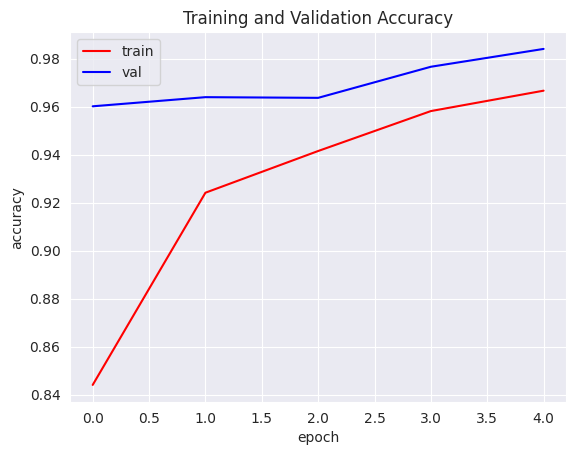

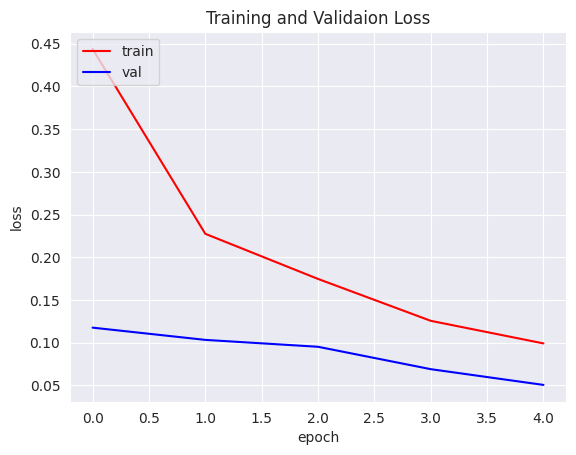

In [25]:
# Visualisasi akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

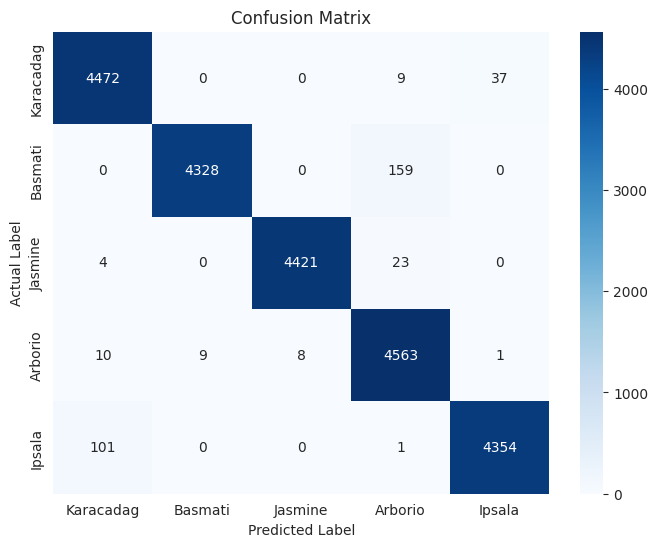


Classification Report:
              precision    recall  f1-score   support

   Karacadag     0.9749    0.9898    0.9823      4518
     Basmati     0.9979    0.9646    0.9810      4487
     Jasmine     0.9982    0.9939    0.9961      4448
     Arborio     0.9596    0.9939    0.9765      4591
      Ipsala     0.9913    0.9771    0.9842      4456

    accuracy                         0.9839     22500
   macro avg     0.9844    0.9839    0.9840     22500
weighted avg     0.9842    0.9839    0.9839     22500


Testing Accuracy: 0.9839


In [26]:
test_generator.reset()  # Reset test generator

# melakukan prediksi
preds = model.predict(test_generator, verbose=0)

# Convert predictions ke class labels
predicted_classes = np.argmax(preds, axis=1)

true_classes = test_generator.classes

class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']  # Replace with your actual class names

# Menampilkan Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Menampilkan Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names, digits=4))

# Menampilkan testing accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTesting Accuracy: {test_accuracy:.4f}")

## Konversi Model

In [27]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert best_model.h5 to model
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-30 23:27:58.143880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746055678.164364    3552 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [28]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

16592

## Inference (Optional)